In [6]:
import calendar
import operator
from collections import Counter, namedtuple
from math import log
from typing import Tuple, Sequence
from itertools import cycle, islice

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
mpl.rcParams["figure.figsize"] = 16, 9

In [8]:
#data = (pd.read_csv("/home/leyht/Downloads/untitled folder/{}.csv".format(k), header=0, index_col=0,
#                    parse_dates=True) for k in calendar.month_name[1:])
#data = pd.concat(data, keys=range(1,13), names=("month", "date"))
#data.to_hdf("data/futureswise.h5", "data", complevel=9, complib="bzip2")

In [9]:
data = pd.read_hdf("data/futureswise.h5")
expirations = pd.read_csv("data/expirations.csv", header=0, usecols=range(1,10),
                          parse_dates=list(range(9)), index_col=0)
termstructure = pd.read_csv("data/8_m_settle.csv", usecols=range(1,10), parse_dates=True,
                            header=0, index_col=0, na_values=0)
symbols = pd.read_csv("data/8_m_symbols.csv", usecols=range(1,10), parse_dates=True,
                      header=0, index_col=0)

In [10]:
for year in data:
    yint = int(year)
    # This internally raises an exception but it's just some localization problem.
    # The resulting data seems correct.
    data[year].index = pd.MultiIndex(levels=[data[year].index.levels[0],
                                             data[year].index.levels[1].map(lambda x: pd.Timestamp(yint, x.month, x.day))],
                                     labels=data[year].index.labels)

Exception ignored in: 'pandas._libs.tslib._localize_tso'
Traceback (most recent call last):
  File "pandas/_libs/tslib.pyx", line 4332, in pandas._libs.tslib._get_dst_info (pandas/_libs/tslib.c:72500)
  File "pandas/_libs/tslib.pyx", line 1425, in pandas._libs.tslib._get_utcoffset (pandas/_libs/tslib.c:27137)
AttributeError: 'Int64Index' object has no attribute 'utcoffset'
Exception ignored in: 'pandas._libs.tslib._localize_tso'
Traceback (most recent call last):
  File "pandas/_libs/tslib.pyx", line 4332, in pandas._libs.tslib._get_dst_info (pandas/_libs/tslib.c:72500)
  File "pandas/_libs/tslib.pyx", line 1425, in pandas._libs.tslib._get_utcoffset (pandas/_libs/tslib.c:27137)
AttributeError: 'Int64Index' object has no attribute 'utcoffset'
Exception ignored in: 'pandas._libs.tslib._localize_tso'
Traceback (most recent call last):
  File "pandas/_libs/tslib.pyx", line 4332, in pandas._libs.tslib._get_dst_info (pandas/_libs/tslib.c:72500)
  File "pandas/_libs/tslib.pyx", line 1425, in 

In [11]:
# Concatenate the columns to get a large series of spread prices.
spreads = pd.concat((data[year].dropna() for year in data))

In [12]:
date_mask = spreads.index.droplevel(0).isin(termstructure.index)
filtered_spreads = spreads.where(date_mask).dropna()

In [13]:
# These are the spread prices loaded from file.
filtered_spreads[:,"2017-04-27"]

month
6    -0.200
7     0.450
8    -0.300
9     0.375
10    0.100
11    0.200
12   -0.800
dtype: float64

In [14]:
# These are spread prices calculated from the term structure.
# Why are these different from each other?
termstructure.loc["2017-04-27"].aggregate(lambda x: [-x[i] + 2*x[i+1] - x[i+2] for i in range(6)])

[-0.27000000000000135,
 0.46000000000000085,
 -0.3100000000000005,
 0.41999999999999815,
 0.050000000000004263,
 0.24999999999999645]

# Problem

Doesn't seem like I can fit the new data of spread prices to the term structures. 

Better to get the spread prices in their necessary representation directly from the old proven term structure data.

In [15]:
assert expirations.shape == termstructure.shape
assert expirations.index.equals(termstructure.index)

In [16]:
long_prices = termstructure.apply(lambda x: [np.nan] + [2*x[i] - x[i-1] - x[i+1] for i in range(1, len(x) - 1)] + [np.nan],
                                  axis=1, reduce=False)
long_prices.dropna(axis=(0,1), how="all", inplace=True)

In [17]:
threshold_date = "2006-10-23"

In [18]:
long_prices_thresh = long_prices[threshold_date:]
day_diff = pd.Series(long_prices_thresh.index[1:]- long_prices_thresh.index[:-1])
count_day_diff = Counter(day_diff)

In [19]:
# There's not much difference between two index dates lying next to each other.
# Further modifications aren't necessary.
count_day_diff

Counter({Timedelta('1 days 00:00:00'): 2081,
         Timedelta('2 days 00:00:00'): 24,
         Timedelta('3 days 00:00:00'): 478,
         Timedelta('4 days 00:00:00'): 70,
         Timedelta('5 days 00:00:00'): 2})

In [20]:
termstructure_thresh = termstructure[threshold_date:]
assert len(termstructure_thresh) == len(long_prices_thresh)

In [21]:
days_into_future = 1

In [22]:
y = pd.concat((long_prices_thresh.iloc[days_into_future:][column]
               for column in long_prices_thresh))
x = termstructure_thresh.iloc[:-days_into_future]
for i in range(len(long_prices_thresh.columns) - 1):
    x = x.append(termstructure_thresh.iloc[:-days_into_future])
assert len(y) == len(x)
x = x.where((np.tile(y.notnull().values, (len(x.columns),1)).T)).dropna(axis=0, how="all")
y = y.where(y.notnull()).dropna()
assert len(y) == len(x)

In [23]:
#x.to_hdf("data/futureswise_mapping.h5", "x", complevel=9, complib="bzip2")
#y.to_hdf("data/futureswise_mapping.h5", "y", complevel=9, complib="bzip2")

# Not we've prepared the data

Cool. So $x$ is the data mapping to target $y$. But now I'd like to split in into test and validation set similar to the other representation.

In [24]:
split_between_years = np.append(0, y.index.get_loc("2017-05-11") + 1)
splits = split_between_years
split_between_years

array([    0,  2655,  5310,  7965, 10593, 13047, 15193])

In [25]:
def split_indices(a: int, b: int, val_split=0.15, test_split=0.15):
    half = int((b - a) / 2)
    val_len = int(half * val_split)
    test_len = int(half * test_split)
    val1 = a + half - val_len - test_len
    test1 = a + half - test_len
    data = a + half
    val2 = b - val_len - test_len
    test2 = b - test_len
    return a, val1, test1, data, val2, test2, b

In [26]:
def splitted_dataset(dataset, splits: Sequence):
    indices = pd.DataFrame((split_indices(splits[i], splits[i+1]) for i in range(len(splits) - 1)),
                           columns=("data1", "val1", "test1", "data2", "val2", "test2", "end"))
    d1, v1, t1, d2, v2, t2 = ([dataset.iloc[a:b] for a, b in zip(indices.iloc[:,i], indices.iloc[:,i+1])]
                              for i in range(len(indices.columns) - 1))
    return pd.concat(d1 + d2), pd.concat(v1 + v2), pd.concat(t1 + t2)

In [27]:
indices = pd.DataFrame((split_indices(splits[i], splits[i+1]) for i in range(len(splits) - 1)),
                       columns=("data1", "val1", "test1", "data2", "val2", "test2", "end"))
indices

,data1,val1,test1,data2,val2,test2,end
0,0,929,1128,1327,2257,2456,2655
1,2655,3584,3783,3982,4912,5111,5310
2,5310,6239,6438,6637,7567,7766,7965
3,7965,8885,9082,9279,10199,10396,10593
4,10593,11452,11636,11820,12679,12863,13047
5,13047,13800,13960,14120,14873,15033,15193


In [28]:
xdata, xval, xtest = splitted_dataset(x, split_between_years)
assert len(xdata) + len(xval) + len(xtest) == len(x)
ydata, yval, ytest = splitted_dataset(y, split_between_years)
assert len(ydata) + len(yval) + len(ytest) == len(y)

# Incorporate information about futures month into data

It seems a bit difficult to train a large network which has distinguish different spread prices by month by itself. So my idea would be to train twelve different networks (because there are twelve months obviously) directly with the different months' prices.

Now I have just to think about how I get these spreads out of the data. Maybe with the `8_m_symbols.csv`?

In [29]:
symbols_to_month = {"F":"January",
                    "G":"February",
                    "H":"March",
                    "J":"April",
                    "K":"May",
                    "M":"June",
                    "N":"July",
                    "Q":"August",
                    "U":"September",
                    "V":"October",
                    "X":"November",
                    "Z":"December"}

In [30]:
def year_month_repr(self):
    return str((self.year, self.month))
YearMonth = namedtuple("YearMonth", ["year", "month"])
YearMonth.__repr__ = year_month_repr
symbols_short = symbols.applymap(lambda x: YearMonth(int(x[-3:-1]), operator.indexOf(calendar.month_name, symbols_to_month[x[0]])) if isinstance(x, str) else x)

In [31]:
count_ym = Counter(symbols_short.values.reshape(symbols_short.size))

In [32]:
def filter_by_yearmonth(dataframe, year, month):
    return dataframe.applymap(lambda x: True if isinstance(x, YearMonth) and x.year == year and x.month == month else False)

In [33]:
mask_dict = {key:filter_by_yearmonth(symbols_short, key.year, key.month) for key in count_ym
             if isinstance(key, YearMonth)}

In [34]:
long_prices = termstructure.apply(lambda x: [np.nan] + [2*x[i] - x[i-1] - x[i+1] for i in range(1, len(x) - 1)] + [np.nan],
                                  axis=1, reduce=False)
assert long_prices.index.equals(symbols_short.index)
assert long_prices.shape == symbols_short.shape

## Some explanation in between

Up to now I prepared masks for all spread prices in `mask_dict`. With this one can select spreads with the `where` method.

Next I need all the x-y-mappings from the term structure to the spread prices of the next day with appropricate shape. There will be such a mapping for each month.

In [35]:
test_16_05 = long_prices.where(mask_dict[YearMonth(16,5)]).dropna(how="all", axis=(0,1))

In [36]:
y_16_05 = pd.concat((test_16_05.iloc[days_into_future:][col] for col in test_16_05)).dropna().sort_index()
x_16_05 = termstructure.loc[test_16_05.index].iloc[:-days_into_future]

In [37]:
c_16_05 = Counter(y_16_05.index - x_16_05.index)
for key in c_16_05:
    assert key.days <= 5

The code above was just playing around and testing. Now let's make a function out of this.

In [38]:
def x_y_mapping(long_prices, termstructure, mask, days_into_future=1, yearmonth=None):
    prices = long_prices.where(mask).dropna(how="all", axis=(0,1))
    try:
        if yearmonth:
            assert not prices.empty, "There are no spread prices for year {} and month {}.".format(yearmonth.year,
                                                                                                   yearmonth.month)
        else:
            assert not prices.empty
    except AssertionError as e:
        print(e)
        return None
    y = pd.concat((prices.iloc[days_into_future:][column] for column in prices)).dropna().sort_index()
    x = termstructure.loc[prices.index].iloc[:-days_into_future]
    assert len(x) == len(y)
    counter = Counter(y.index - x.index)
    for key in counter:
        try:
            if yearmonth:
                assert key.days <= 5, str(counter) + "\n" + "At year {} and month {}".format(yearmonth.year, yearmonth.month)
            else:
                assert key.days <= 5, str(counter)
        except AssertionError as e:
            print(e)
    return x, y

In [39]:
mapping_dict = {key:x_y_mapping(long_prices, termstructure, mask_dict[key], yearmonth=key) for key in mask_dict}

There are no spread prices for year 4 and month 5.
There are no spread prices for year 4 and month 6.
There are no spread prices for year 4 and month 8.
There are no spread prices for year 4 and month 11.
There are no spread prices for year 5 and month 2.
There are no spread prices for year 4 and month 9.
There are no spread prices for year 5 and month 5.
There are no spread prices for year 5 and month 1.
There are no spread prices for year 5 and month 8.
There are no spread prices for year 5 and month 3.
There are no spread prices for year 5 and month 11.
There are no spread prices for year 5 and month 6.
There are no spread prices for year 6 and month 2.
There are no spread prices for year 5 and month 10.
There are no spread prices for year 6 and month 5.
There are no spread prices for year 5 and month 12.
There are no spread prices for year 6 and month 8.
There are no spread prices for year 6 and month 3.
There are no spread prices for year 6 and month 6.
There are no spread prices 

In [40]:
sorted_keys = [item[0] for item in mapping_dict.items() if item[1]]
sorted_keys.sort()
years = list({key[0] for key in sorted_keys})
years.sort()
[str("%02d" % year) for year in years]

['04', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17']

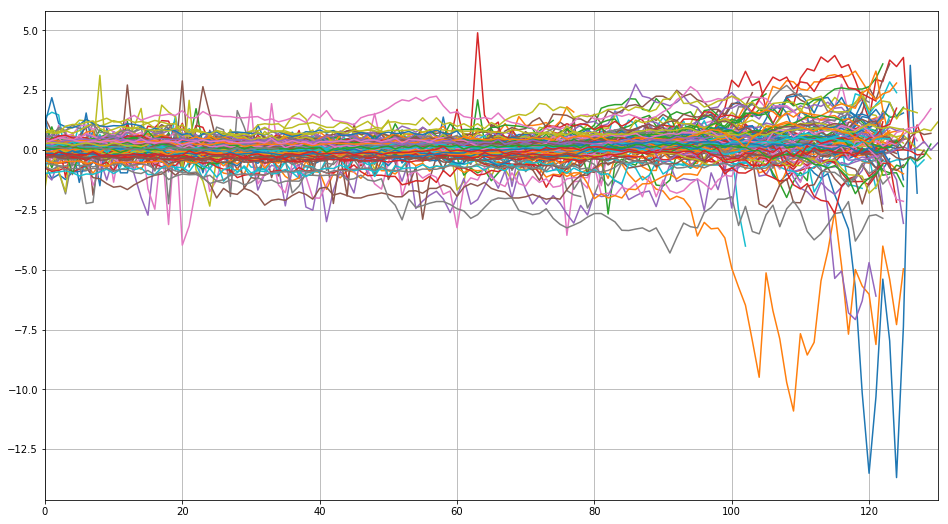

In [41]:
for key in sorted_keys:
    x, y = mapping_dict[key]
    plt.plot(np.arange(len(y)), y.values)
plt.xlim(0,130)
plt.grid()
plt.show()

In [42]:
y = pd.concat((mapping_dict[key][1] for key in sorted_keys), keys=sorted_keys, names=["year", "month"])
x = pd.concat((mapping_dict[key][0] for key in sorted_keys), keys=sorted_keys, names=["year", "month"])
assert len(x) == len(y)

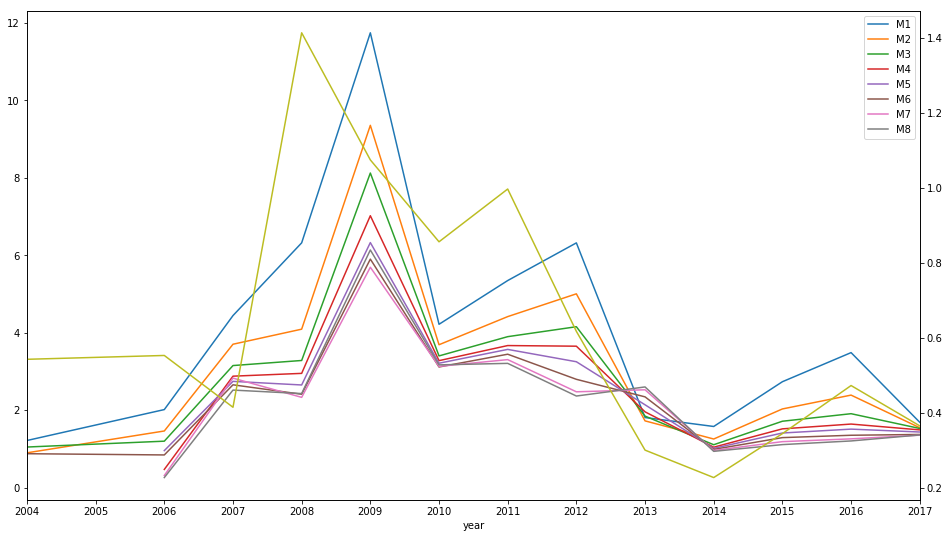

In [43]:
x.groupby("year").std().plot()
y.groupby("year").std().plot(secondary_y=True)
plt.xticks(np.arange(4,18), np.arange(2004,2018))
plt.show()

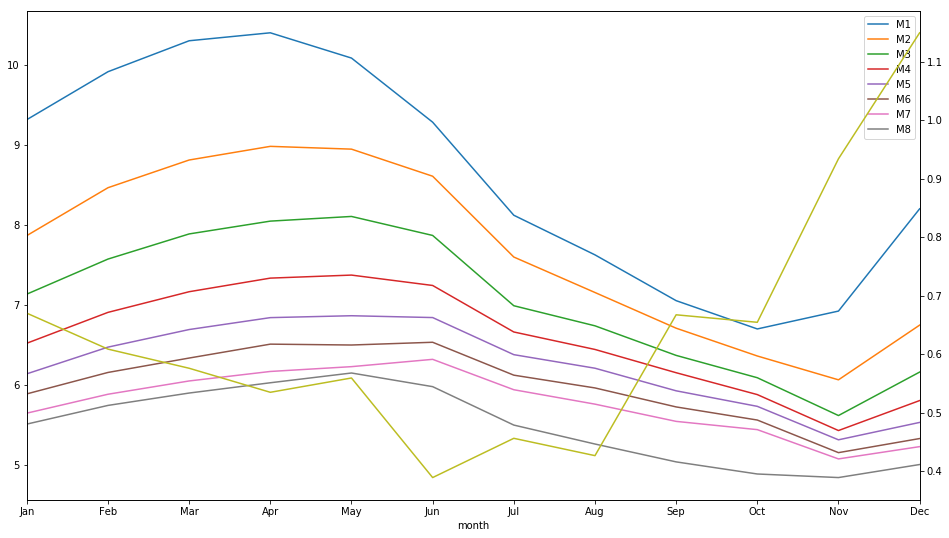

In [44]:
x.groupby("month").std().plot()
y.groupby("month").std().plot(secondary_y=True)
plt.xticks(np.arange(1,13), calendar.month_abbr[1:])
plt.show()

In [45]:
for month_nr in range(1,13):
    assert len(y.loc(axis=0)[:,month_nr]) == len(x.loc(axis=0)[:,month_nr])
    print(calendar.month_name[month_nr], len(y.loc(axis=0)[:,month_nr]))

January 1281
February 1239
March 1238
April 1329
May 1289
June 1279
July 1328
August 1224
September 1236
October 1281
November 1256
December 1213


In [46]:
#x.to_hdf("data/futures_per_year_and_month.h5", "x", complevel=9, complib="bzip2")
#y.to_hdf("data/futures_per_year_and_month.h5", "y", complevel=9, complib="bzip2")

# I'll just start here anew

Idea: Work on the ordering of the data. At the moment there is this mapping:

* M1 ... M8 -> Spread

Better would be something like this:

* Jan ... Dec -> Spread
* Just map the second level of the row multiindex to column headers

In [47]:
x = pd.read_hdf("data/futures_per_year_and_month.h5", "x")
y = pd.read_hdf("data/futures_per_year_and_month.h5", "y")

In [64]:
x.loc(axis=0)[:, :, "2017-05-10"]

M1     M2     M3    M4    M5     M6    M7     M8
year month date                                                           
17   6     2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     7     2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     8     2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     9     2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     10    2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33
     11    2017-05-10  11.55  12.47  13.68  14.4  15.3  15.73  16.1  16.33

In [66]:
y.loc(axis=0)[:, :, "2017-05-5"]

year  month  date      
17    6      2017-05-05   -0.10
      7      2017-05-05    0.43
      8      2017-05-05   -0.32
      9      2017-05-05    0.43
      10     2017-05-05    0.05
      11     2017-05-05    0.24
dtype: float64

In [67]:
symbols.loc["2017-05-5"]

M1    K (May 17)
M2    M (Jun 17)
M3    N (Jul 17)
M4    Q (Aug 17)
M5    U (Sep 17)
M6    V (Oct 17)
M7    X (Nov 17)
M8    Z (Dec 17)
Name: 2017-05-05 00:00:00, dtype: object

In [50]:
symbols_short.loc["2017-01-20"]

M1    (17, 2)
M2    (17, 3)
M3    (17, 4)
M4    (17, 5)
M5    (17, 6)
M6    (17, 7)
M7    (17, 8)
M8    (17, 9)
Name: 2017-01-20 00:00:00, dtype: object

In [62]:
x.apply(lambda x: [i for i in 
                   islice(cycle(range(1, 13)), x.name[1] + 10, x.name[1] + 18)], axis=1)

M1  M2  M3  M4  M5  M6  M7  M8
year month date                                      
4    7     2004-05-24   6   7   8   9  10  11  12   1
           2004-05-25   6   7   8   9  10  11  12   1
           2004-05-26   6   7   8   9  10  11  12   1
           2004-05-27   6   7   8   9  10  11  12   1
           2004-05-28   6   7   8   9  10  11  12   1
           2004-06-01   6   7   8   9  10  11  12   1
           2004-06-02   6   7   8   9  10  11  12   1
           2004-06-03   6   7   8   9  10  11  12   1
           2004-06-04   6   7   8   9  10  11  12   1
           2004-06-07   6   7   8   9  10  11  12   1
           2004-06-08   6   7   8   9  10  11  12   1
           2004-06-09   6   7   8   9  10  11  12   1
           2004-06-10   6   7   8   9  10  11  12   1
           2004-06-14   6   7   8   9  10  11  12   1
     10    2004-08-23   9  10  11  12   1   2   3   4
           2004-08-24   9  10  11  12   1   2   3   4
           2004-08-25   9  10  11  12   1   2   3   4
           2004-08-26   9  10  11  12   1   2   3   4
           2004-08-27   9  10  11  12   1   2   3   4
           2004-08-30   9  10  11  12   1   2   3   4
           2004-08-31   9  10  11  12   1   2   3   4
           2004-09-01   9  10  11  12   1   2   3   4
           2004-09-02   9  10  11  12   1   2   3   4
           2004-09-03   9  10  11  12   1   2   3   4
           2004-09-07   9  10  11  12   1   2   3   4
           2004-09-08   9  10  11  12   1   2   3   4
           2004-09-09   9  10  11  12   1   2   3   4
           2004-09-10   9  10  11  12   1   2   3   4
           2004-09-13   9  10  11  12   1   2   3   4
6    1     2005-11-21  12   1   2   3   4   5   6   7
...                    ..  ..  ..  ..  ..  ..  ..  ..
17   10    2017-04-21   9  10  11  12   1   2   3   4
           2017-04-24   9  10  11  12   1   2   3   4
           2017-04-25   9  10  11  12   1   2   3   4
           2017-04-26   9  10  11  12   1   2   3   4
           2017-04-27   9  10  11  12   1   2   3   4
           2017-04-28   9  10  11  12   1   2   3   4
           2017-05-01   9  10  11  12   1   2   3   4
           2017-05-02   9  10  11  12   1   2   3   4
           2017-05-03   9  10  11  12   1   2   3   4
           2017-05-04   9  10  11  12   1   2   3   4
           2017-05-05   9  10  11  12   1   2   3   4
           2017-05-08   9  10  11  12   1   2   3   4
           2017-05-09   9  10  11  12   1   2   3   4
           2017-05-10   9  10  11  12   1   2   3   4
     11    2017-04-19  10  11  12   1   2   3   4   5
           2017-04-20  10  11  12   1   2   3   4   5
           2017-04-21  10  11  12   1   2   3   4   5
           2017-04-24  10  11  12   1   2   3   4   5
           2017-04-25  10  11  12   1   2   3   4   5
           2017-04-26  10  11  12   1   2   3   4   5
           2017-04-27  10  11  12   1   2   3   4   5
           2017-04-28  10  11  12   1   2   3   4   5
           2017-05-01  10  11  12   1   2   3   4   5
           2017-05-02  10  11  12   1   2   3   4   5
           2017-05-03  10  11  12   1   2   3   4   5
           2017-05-04  10  11  12   1   2   3   4   5
           2017-05-05  10  11  12   1   2   3   4   5
           2017-05-08  10  11  12   1   2   3   4   5
           2017-05-09  10  11  12   1   2   3   4   5
           2017-05-10  10  11  12   1   2   3   4   5

[15193 rows x 8 columns]

In [136]:
symbols_month = symbols_short.applymap(lambda x: x if isinstance(x, float) else x[1]).interpolate(axis=1).apply(
                    lambda x: [i for i in range(int(x[3]) - 3, int(x[3]) + 5)], axis=1)

In [139]:
def month_to_header(x):
    global symbols_month
    x.index = symbols_month.loc[x.name[2]]
    return pd.Series({k:x.get(k, default=np.nan) for k in range(1, 13)})
x_yearly = x.apply(month_to_header, axis=1)

In [148]:
x_yearly.tail()

1   2   3   4      5      6      7      8      9   \
year month date                                                            
17   11    2017-05-04 NaN NaN NaN NaN  11.73  12.67  13.60  14.11  14.95   
           2017-05-05 NaN NaN NaN NaN  11.78  12.67  13.66  14.22  15.10   
           2017-05-08 NaN NaN NaN NaN  11.40  12.50  13.70  14.33  15.18   
           2017-05-09 NaN NaN NaN NaN  11.40  12.48  13.67  14.35  15.15   
           2017-05-10 NaN NaN NaN NaN  11.55  12.47  13.68  14.40  15.30   

                          10     11     12  
year month date                             
17   11    2017-05-04  15.35  15.80  15.95  
           2017-05-05  15.55  15.95  16.11  
           2017-05-08  15.63  16.00  16.20  
           2017-05-09  15.62  16.00  16.19  
           2017-05-10  15.73  16.10  16.33

In [189]:
for month in range(1, 13):
    assert len(x.loc(axis=0)[:, month]) == len(y.loc(axis=0)[:, month])
    assert len(x_yearly.loc(axis=0)[:, month]) == len(y.loc(axis=0)[:, month])
#x_yearly.to_hdf("data/futures_per_year_and_month.h5", "x_yearly", complevel=9, complib="bzip2")